In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# GET THE DATAFRAME.

import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
# df_path = "../../data/raw/hedges-all.tsv"
# df_path = "../../data/raw/studytype_multiclass.tsv"
df = pd.read_csv(df_path, sep="\t")
# df = pd.concat([df * 5])

In [3]:
# PERFORM DATA PROCESSING (LEMATIZATION ETC), GET TFIDF SCORES AND FEATURE NAMES.
# COULD be parallelised
from eppi_text_classification import (
    get_features,
    get_labels,
    get_tfidf_and_names,
)

word_features = get_features(
    df,
    # title_key="ti",
    # abstract_key="ab",
    # title_key="TI",
    # abstract_key="AB",
)


number of processes: 12
number of processes: 12


In [4]:
labels = get_labels(
    df,
    # label_column_name="is_rct",
    # positive_class_value="1",
    # label_column_name="Class",
    # positive_class_value="CaseControlStudies",
)
tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [5]:
# PERFORM AN OPTUNA HYPERPARAMETER SEARCH, CAN CHANGE THE SEARCH SPACE IN OPT.PY

from eppi_text_classification import OptunaHyperparameterOptimisation

# hyperparam_ranges = {
#     "min_child_samples": {"low": 1, "high": 30, "log": False},
#     "learning_rate": {"low": 0.1, "high": 0.6, "log": False},
#     "num_leaves": {"low": 2, "high": 50, "log": False},
#     "n_estimators": {"low": 100, "high": 100, "log": False},
#     "min_split_gain": {"low": 1e-6, "high": 10, "log": False},
#     "min_child_weight": {"low": 1e-6, "high": 1e-1, "log": True},
#     "reg_alpha": {"low": 1e-5, "high": 10, "log": True},
#     "reg_lambda": {"low": 1e-5, "high": 10, "log": True},
#     "linear_tree": {"value": True},
# }

hyperparam_ranges = {
    "min_child_samples": {"low": 1, "high": 30, "log": False, "suggest_type": "int"},
    "learning_rate": {"low": 0.1, "high": 0.6, "log": False, "suggest_type": "float"},
    "num_leaves": {"low": 2, "high": 50, "log": False, "suggest_type": "int"},
    "n_estimators": {"low": 100, "high": 500, "log": False, "suggest_type": "int"},
    "min_split_gain": {"low": 1e-6, "high": 10, "log": False, "suggest_type": "float"},
    "min_child_weight": {
        "low": 1e-6,
        "high": 1e-1,
        "log": True,
        "suggest_type": "float",
    },
    "reg_alpha": {"low": 1e-5, "high": 10, "log": True, "suggest_type": "float"},
    "reg_lambda": {"low": 1e-5, "high": 10, "log": True, "suggest_type": "float"},
}


optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "lightgbm",
    max_n_search_iterations=300,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
    timeout=1000,
    use_early_terminator=True,
    max_stagnation_iterations=1000,
    wilcoxon_trial_pruner_threshold=None,
    use_worse_than_first_two_pruner=False,
    user_selected_hyperparameter_ranges=hyperparam_ranges,
)

optimiser.delete_optuna_study("lgbm_binary")
best_params = optimiser.optimise_hyperparameters(study_name="lgbm_binary")

Number of processes: 12
sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db
final ranges: {'max_depth': {'low': 1, 'high': 15, 'log': False, 'suggest_type': 'int'}, 'min_child_samples': {'low': 1, 'high': 30, 'log': False, 'suggest_type': 'int'}, 'num_leaves': {'low': 2, 'high': 50, 'log': False, 'suggest_type': 'int'}, 'n_estimators': {'low': 100, 'high': 500, 'log': False, 'suggest_type': 'int'}, 'learning_rate': {'low': 0.1, 'high': 0.6, 'log': False, 'suggest_type': 'float'}, 'min_split_gain': {'low': 1e-06, 'high': 10, 'log': False, 'suggest_type': 'float'}, 'min_child_weight': {'low': 1e-06, 'high': 0.1, 'log': True, 'suggest_type': 'float'}, 'reg_alpha': {'low': 1e-05, 'high': 10, 'log': True, 'suggest_type': 'float'}, 'reg_lambda': {'low': 1e-05, 'high': 10, 'log': True, 'suggest_type': 'float'}, 'data_sample_strategy': {'value': 'bagging', 'suggest_type': 'singular'}, 'boosting_type': {'value': 'gbdt', 'suggest_type': 'singular'}

[I 2025-02-23 13:51:47,019] A new study created in RDB with name: lgbm_binary
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:404: ExperimentalWarning: BestValueStagnationEvaluator is experimental (supported from v3.4.0). The interface can change in the future.
  improvement_evaluator=BestValueStagnationEvaluator(
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:407: ExperimentalWarning: StaticErrorEvaluator is experimental (supported from v3.2.0). The interface can change in the future.
  error_evaluator=StaticErrorEvaluator(constant=0),
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:403: ExperimentalWarning: Terminator is experimental (supported from v3.2.0). The interface can change in the future.
  terminator = Terminator(
/Users/sjmolyneux/Document

Finished trial with scores: [0.899002493765586, 0.8889443059019119, 0.9546908315565031]
Finished trial with scores: [0.9238570241064007, 0.8347464671654197, 0.9378997867803838]


[I 2025-02-23 13:51:47,930] Trial 1 finished with value: 0.9142125437413336 and parameters: {'max_depth': 2, 'min_child_weight': 1.01697346361078e-06, 'num_leaves': 6, 'reg_alpha': 3.797228617135805, 'n_estimators': 304, 'learning_rate': 0.1980863644157955, 'min_split_gain': 1.7086280623851469, 'reg_lambda': 1.22457186147429, 'min_child_samples': 27}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:48,014] Trial 7 finished with value: 0.8988344260174014 and parameters: {'learning_rate': 0.3343579198708323, 'num_leaves': 20, 'n_estimators': 104, 'min_child_weight': 0.00024642826328433133, 'reg_lambda': 2.128588275177813e-05, 'max_depth': 1, 'min_split_gain': 7.4202481029757825, 'min_child_samples': 18, 'reg_alpha': 0.0516388553903958}. Best is trial 1 with value: 0.9142125437413336.


Finished trial with scores: [0.640149625935162, 0.5655860349127182, 0.7269012082444918]
Finished trial with scores: [0.8179551122194514, 0.7901911886949293, 0.896499644633973]
Finished trial with scores: [0.8630922693266834, 0.8051537822111389, 0.9433191186922529]
Finished trial with scores: [0.8507065669160432, 0.7747298420615129, 0.916133617626155]
Finished trial with scores: [0.9019118869492934, 0.8763092269326684, 0.9342572850035537]


[I 2025-02-23 13:51:48,199] Trial 8 finished with value: 0.6442122896974573 and parameters: {'n_estimators': 462, 'min_split_gain': 9.719965017129825, 'reg_alpha': 0.12195634326292004, 'max_depth': 11, 'min_child_weight': 6.817572414697349e-06, 'learning_rate': 0.5796476213319742, 'min_child_samples': 19, 'num_leaves': 35, 'reg_lambda': 0.0113481232161062}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:48,209] Trial 2 finished with value: 0.8348819818494512 and parameters: {'learning_rate': 0.38515704428821995, 'num_leaves': 44, 'reg_alpha': 1.545724952864946, 'min_child_samples': 21, 'n_estimators': 457, 'min_child_weight': 2.4218043722504486e-05, 'min_split_gain': 3.2693815820483727, 'reg_lambda': 0.85914419244034, 'max_depth': 3}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:48,311] Trial 6 finished with value: 0.870521723410025 and parameters: {'reg_lambda': 0.016491003041626998, 'num_leaves': 45, 'min_split_gain': 5.700423464118205, 'n_

Finished trial with scores: [0.7474646716541979, 0.8457190357439734, 0.9470504619758351]
Finished trial with scores: [0.8671654197838736, 0.7729842061512886, 0.9255508173418621]
Finished trial with scores: [0.9086450540315876, 0.7775561097256859, 0.9347903340440654]
Finished trial with scores: [0.8314214463840399, 0.7479634247714048, 0.8961442786069651]


[I 2025-02-23 13:51:48,457] Trial 11 finished with value: 0.8467447231246688 and parameters: {'min_child_weight': 1.9440466174343724e-06, 'learning_rate': 0.35306324693284663, 'max_depth': 15, 'reg_lambda': 0.6075588944914161, 'num_leaves': 8, 'min_split_gain': 0.30265913928073107, 'reg_alpha': 0.002782591407742363, 'min_child_samples': 19, 'n_estimators': 470}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:48,525] Trial 10 finished with value: 0.8552334810923415 and parameters: {'min_child_weight': 0.04161625419516286, 'max_depth': 8, 'reg_lambda': 5.2212597473127255e-05, 'n_estimators': 326, 'reg_alpha': 9.358177976727946, 'learning_rate': 0.20356152342426556, 'num_leaves': 42, 'min_split_gain': 2.9421711784040125, 'min_child_samples': 12}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:48,541] Trial 0 finished with value: 0.8736638326004463 and parameters: {'max_depth': 2, 'min_child_samples': 7, 'reg_alpha': 6.699532298868397e-05, 'learnin

Finished trial with scores: [0.7192019950124687, 0.7837073981712386, 0.6302416488983653]


[I 2025-02-23 13:51:48,708] Trial 13 finished with value: 0.711050347360691 and parameters: {'learning_rate': 0.4383552162303649, 'num_leaves': 32, 'n_estimators': 100, 'min_child_weight': 0.0004978264595678147, 'reg_lambda': 0.028503478025108404, 'max_depth': 14, 'min_split_gain': 0.7219903661326901, 'min_child_samples': 27, 'reg_alpha': 0.01612016927030217}. Best is trial 1 with value: 0.9142125437413336.


Finished trial with scores: [0.7403158769742312, 0.726267664172901, 0.9466950959488273]
Finished trial with scores: [0.8661679135494597, 0.8605153782211139, 0.9484719260838663]


[I 2025-02-23 13:51:49,163] Trial 12 finished with value: 0.8044262123653199 and parameters: {'max_depth': 8, 'min_child_weight': 0.0016120497658445696, 'num_leaves': 9, 'reg_alpha': 0.002321310935847109, 'n_estimators': 323, 'learning_rate': 0.3398739111257184, 'min_split_gain': 1.020307810026054, 'reg_lambda': 0.3131024937183061, 'min_child_samples': 12}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:49,290] Trial 14 finished with value: 0.8917184059514799 and parameters: {'n_estimators': 258, 'min_split_gain': 1.3051289776456534, 'reg_alpha': 1.1231367956142955, 'max_depth': 11, 'min_child_weight': 0.0031211155556886655, 'learning_rate': 0.26964103070169365, 'min_child_samples': 21, 'num_leaves': 5, 'reg_lambda': 0.3564117452656329}. Best is trial 1 with value: 0.9142125437413336.


Finished trial with scores: [0.7417290108063175, 0.6379052369077307, 0.5245202558635395]
Finished trial with scores: [0.8364921030756443, 0.8072319201995012, 0.9163113006396588]
Finished trial with scores: [0.9040731504571904, 0.8802992518703242, 0.9145344705046198]
Finished trial with scores: [0.9374896093100582, 0.8039900249376559, 0.9625088841506751]


[I 2025-02-23 13:51:49,412] Trial 16 finished with value: 0.6347181678591959 and parameters: {'reg_lambda': 0.0009666950597496854, 'num_leaves': 38, 'min_split_gain': 3.1450369368161235, 'n_estimators': 151, 'max_depth': 8, 'learning_rate': 0.5244081630049143, 'reg_alpha': 0.00010317102623565177, 'min_child_samples': 18, 'min_child_weight': 0.00290774421603299}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:49,463] Trial 18 finished with value: 0.8533451079716015 and parameters: {'reg_lambda': 0.00025581002629642736, 'learning_rate': 0.25366931439513696, 'min_child_weight': 0.09334832077863822, 'reg_alpha': 0.00013566233783802932, 'max_depth': 3, 'n_estimators': 333, 'min_split_gain': 6.50969720696879, 'min_child_samples': 27, 'num_leaves': 18}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:49,471] Trial 15 finished with value: 0.8996356242773782 and parameters: {'learning_rate': 0.2875395624285251, 'num_leaves': 15, 'reg_alpha': 0.0137309077

Finished trial with scores: [0.8093100581878637, 0.6530340814630091, 0.7405828002842929]
Finished trial with scores: [0.9496259351620948, 0.8944305901911888, 0.9653518123667377]
Finished trial with scores: [0.9596009975062345, 0.9077306733167082, 0.9614427860696517]
Finished trial with scores: [0.8911886949293433, 0.7012468827930175, 0.876954513148543]
Finished trial with scores: [0.900665004156276, 0.887448046550291, 0.9577114427860697]


[I 2025-02-23 13:51:49,712] Trial 17 finished with value: 0.7343089799783886 and parameters: {'min_child_weight': 0.01920090685233176, 'learning_rate': 0.42882816452059547, 'reg_alpha': 0.0017852510555754191, 'max_depth': 10, 'min_child_samples': 18, 'n_estimators': 472, 'min_split_gain': 1.9974072877199691, 'reg_lambda': 0.005609656519695088, 'num_leaves': 4}. Best is trial 1 with value: 0.9142125437413336.
[I 2025-02-23 13:51:49,720] Trial 21 finished with value: 0.9364694459066737 and parameters: {'max_depth': 6, 'min_child_samples': 30, 'reg_lambda': 5.7705096632805075, 'min_split_gain': 0.17913132197081882, 'reg_alpha': 1.2119834705253017e-05, 'learning_rate': 0.15260306798272305, 'num_leaves': 12, 'n_estimators': 276, 'min_child_weight': 1.7328894644817712e-06}. Best is trial 21 with value: 0.9364694459066737.
[I 2025-02-23 13:51:49,739] Trial 20 finished with value: 0.942924818964198 and parameters: {'min_child_weight': 1.0454947768751088e-06, 'max_depth': 6, 'reg_lambda': 9.953

Finished trial with scores: [0.9093931837073983, 0.826101413133832, 0.9538024164889837]
Finished trial with scores: [0.9368246051537823, 0.8768079800498754, 0.9658848614072494]
Finished trial with scores: [0.9336658354114713, 0.9293433083956775, 0.9639303482587065]
Finished trial with scores: [0.9496259351620948, 0.9110556940980882, 0.9626865671641791]


[I 2025-02-23 13:51:50,095] Trial 27 finished with value: 0.896432337776738 and parameters: {'learning_rate': 0.1544148859661582, 'num_leaves': 2, 'reg_alpha': 0.00040850363082785995, 'min_child_samples': 14, 'n_estimators': 259, 'min_child_weight': 1.8667078089866164e-06, 'min_split_gain': 4.372795896846499, 'reg_lambda': 9.96230991191718, 'max_depth': 5}. Best is trial 20 with value: 0.942924818964198.
[I 2025-02-23 13:51:50,196] Trial 32 finished with value: 0.9265058155369691 and parameters: {'min_child_weight': 1.2840988386469815e-06, 'learning_rate': 0.11078739092072454, 'reg_alpha': 1.6325905064449872e-05, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 220, 'min_split_gain': 2.2995332130455015, 'reg_lambda': 5.432773651923399, 'num_leaves': 13}. Best is trial 20 with value: 0.942924818964198.
[I 2025-02-23 13:51:50,290] Trial 30 finished with value: 0.9411227321414541 and parameters: {'max_depth': 5, 'min_child_samples': 30, 'reg_lambda': 6.902119051102629, 'min_split_

Finished trial with scores: [0.9122194513715711, 0.8108063175394846, 0.9598436389481165]
Finished trial with scores: [0.9492934330839568, 0.9246882793017457, 0.9587775408670931]
Finished trial with scores: [0.9344970906068163, 0.8312551953449709, 0.9406538734896944]
Finished trial with scores: [0.9326683291770573, 0.8347464671654198, 0.9381663113006397]


[I 2025-02-23 13:51:50,455] Trial 34 finished with value: 0.8942898026197241 and parameters: {'learning_rate': 0.11717482999092504, 'num_leaves': 12, 'reg_alpha': 1.0316851157882907e-05, 'min_child_samples': 29, 'n_estimators': 202, 'min_child_weight': 7.294719037995932e-06, 'min_split_gain': 2.4368560501555874, 'reg_lambda': 0.07178508433456648, 'max_depth': 6}. Best is trial 20 with value: 0.942924818964198.
[I 2025-02-23 13:51:50,546] Trial 28 finished with value: 0.9021353864804939 and parameters: {'reg_lambda': 9.702718620382528, 'learning_rate': 0.13528043428603254, 'min_child_weight': 1.0110009278369662e-06, 'reg_alpha': 0.0008431962553735147, 'max_depth': 6, 'n_estimators': 253, 'min_split_gain': 4.557175538313926, 'min_child_samples': 4, 'num_leaves': 11}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:50,551] Trial 33 finished with value: 0.9442530844175986 and parameters: {'reg_lambda': 7.730897567460684, 'num_leaves': 12, 'min_split_gain': 0.0057354208

Finished trial with scores: [0.9592684954280964, 0.8749792186201164, 0.9568230277185502]
Finished trial with scores: [0.9090606816292601, 0.7539484621778886, 0.9573560767590619]
Finished trial with scores: [0.9406483790523692, 0.8457190357439733, 0.9426083866382374]
Finished trial with scores: [0.9453034081463009, 0.8430590191188695, 0.9667732764747691]
Finished trial with scores: [0.9364921030756442, 0.8350789692435577, 0.9742359630419332]


[I 2025-02-23 13:51:50,695] Trial 35 finished with value: 0.9303569139222544 and parameters: {'min_child_weight': 8.360042740219034e-06, 'reg_lambda': 0.08293627613133768, 'min_child_samples': 30, 'num_leaves': 13, 'n_estimators': 215, 'reg_alpha': 1.2437719546071053e-05, 'max_depth': 6, 'learning_rate': 0.1017347620286839, 'min_split_gain': 0.07495854284299952}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:50,701] Trial 37 finished with value: 0.8734550735220701 and parameters: {'max_depth': 4, 'min_child_samples': 24, 'reg_lambda': 0.13940284314246082, 'min_split_gain': 2.553234869215742, 'reg_alpha': 3.641881427389057e-05, 'learning_rate': 0.1946118037520471, 'num_leaves': 50, 'n_estimators': 193, 'min_child_weight': 6.450589566172997e-06}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:50,742] Trial 25 finished with value: 0.9096586004781932 and parameters: {'n_estimators': 191, 'min_split_gain': 3.9982759002353943, 'reg_alpha': 1.27049

Finished trial with scores: [0.9508728179551122, 0.8337489609310058, 0.9578891257995736]
Finished trial with scores: [0.9512884455527848, 0.8535328345802161, 0.9523809523809523]
Finished trial with scores: [0.8975893599334996, 0.7700748129675811, 0.9593105899076048]
Finished trial with scores: [0.9522859517871987, 0.8389027431421446, 0.9598436389481166]
Finished trial with scores: [0.9152950955943475, 0.7866999168744805, 0.939410092395167]
Finished trial with scores: [0.943973399833749, 0.8630091438071488, 0.9427860696517413]
Finished trial with scores: [0.9499584372402328, 0.8651704073150458, 0.9678393745557925]


[I 2025-02-23 13:51:50,945] Trial 24 finished with value: 0.9141703015618973 and parameters: {'max_depth': 6, 'min_child_weight': 1.3513220612644335e-06, 'num_leaves': 13, 'reg_alpha': 1.5195026757600038e-05, 'n_estimators': 238, 'learning_rate': 0.1531880490819464, 'min_split_gain': 2.4651275495033214, 'reg_lambda': 7.434736301616613, 'min_child_samples': 1}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:50,972] Trial 39 finished with value: 0.9190674108379845 and parameters: {'learning_rate': 0.19777949738811396, 'num_leaves': 18, 'reg_alpha': 4.033623613822887e-05, 'min_child_samples': 25, 'n_estimators': 188, 'min_child_weight': 6.235104515720432e-06, 'min_split_gain': 0.03624892316962707, 'reg_lambda': 2.3017102985939, 'max_depth': 3}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:51,016] Trial 40 finished with value: 0.8756582542695619 and parameters: {'reg_lambda': 0.09904030627006966, 'num_leaves': 28, 'min_split_gain': 1.3800797872

Finished trial with scores: [0.9276807980049875, 0.8716541978387364, 0.9411869225302061]
Finished trial with scores: [0.9346633416458853, 0.829592684954281, 0.9465174129353234]
Finished trial with scores: [0.9339152119700748, 0.8816292601828761, 0.9520255863539445]
Finished trial with scores: [0.9354114713216958, 0.8773067331670823, 0.9456289978678039]
Finished trial with scores: [0.9371571072319203, 0.7915211970074814, 0.9369225302061123]


[I 2025-02-23 13:51:51,147] Trial 42 finished with value: 0.9165895377642129 and parameters: {'min_child_weight': 3.904610881433118e-06, 'learning_rate': 0.18744599950171353, 'reg_alpha': 5.574571392095625e-05, 'max_depth': 3, 'min_child_samples': 26, 'n_estimators': 153, 'min_split_gain': 1.152616906650921, 'reg_lambda': 2.1432508343247156, 'num_leaves': 19}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:51,197] Trial 45 finished with value: 0.9135073061246434 and parameters: {'n_estimators': 145, 'min_split_gain': 1.4252507237240601, 'reg_alpha': 5.34753884417157e-05, 'max_depth': 3, 'min_child_weight': 3.3904094995418944e-06, 'learning_rate': 0.19003084365967804, 'min_child_samples': 26, 'num_leaves': 21, 'reg_lambda': 2.1298525227521705}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:51,215] Trial 46 finished with value: 0.9225233528356318 and parameters: {'learning_rate': 0.17287046675763665, 'num_leaves': 28, 'n_estimators': 140, 'min

Finished trial with scores: [0.9328345802161263, 0.8793017456359102, 0.9378109452736318]
Finished trial with scores: [0.9213632585203657, 0.8887780548628429, 0.9637526652452025]
Finished trial with scores: [0.9315045719035744, 0.8731504571903573, 0.9443852167732765]
Finished trial with scores: [0.9433083956774729, 0.8884455527847049, 0.9523809523809524]
Finished trial with scores: [0.9285120532003325, 0.8927680798004988, 0.9610874200426439]


[I 2025-02-23 13:51:51,426] Trial 49 finished with value: 0.9246313262094703 and parameters: {'max_depth': 9, 'min_child_weight': 2.992519165824608e-06, 'num_leaves': 8, 'reg_alpha': 0.00017641730363818984, 'n_estimators': 283, 'learning_rate': 0.17251641213564273, 'min_split_gain': 0.838669941334479, 'reg_lambda': 3.0793841884932727, 'min_child_samples': 28}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:51,432] Trial 48 finished with value: 0.9166490903752228 and parameters: {'learning_rate': 0.16878849864078285, 'num_leaves': 22, 'reg_alpha': 0.0002107525973738462, 'min_child_samples': 27, 'n_estimators': 285, 'min_child_weight': 3.253025922675148e-06, 'min_split_gain': 0.7644272853396498, 'reg_lambda': 2.628319202495143, 'max_depth': 7}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:51,482] Trial 50 finished with value: 0.9163467486224027 and parameters: {'reg_lambda': 2.6674513920167655, 'num_leaves': 22, 'min_split_gain': 0.6406101137

Finished trial with scores: [0.9075644222776392, 0.743640897755611, 0.945273631840796]
Finished trial with scores: [0.9157107231920198, 0.8894430590191189, 0.9582444918265813]
Ending process, stopping_event set.
Finished trial with scores: [0.9295095594347464, 0.8721529509559435, 0.9504264392324093]
Ending process, stopping_event set.
Finished trial with scores: [0.9343308395677474, 0.8631753948462179, 0.9529140014214641]
Ending process, stopping_event set.
Finished trial with scores: [0.91571072319202, 0.7787198669991686, 0.9578891257995735]
Ending process, stopping_event set.
Finished trial with scores: [0.8994181213632585, 0.7857024106400664, 0.9554015636105189]
Ending process, stopping_event set.
Finished trial with scores: [0.9023275145469659, 0.7881961762261015, 0.9548685145700071]
Ending process, stopping_event set.


[I 2025-02-23 13:51:51,631] Trial 56 finished with value: 0.8654929839580153 and parameters: {'learning_rate': 0.2360488028550504, 'num_leaves': 9, 'n_estimators': 289, 'min_child_weight': 1.3309401739532236e-05, 'reg_lambda': 0.667372743041262, 'max_depth': 7, 'min_split_gain': 0.6625090283341885, 'min_child_samples': 28, 'reg_alpha': 2.185442793251118e-05}. Best is trial 33 with value: 0.9442530844175986.
[I 2025-02-23 13:51:51,648] The study has been stopped by the terminator.
[I 2025-02-23 13:51:51,648] The study has been stopped by the terminator.
[I 2025-02-23 13:51:51,652] The study has been stopped by the terminator.
[I 2025-02-23 13:51:51,653] The study has been stopped by the terminator.
[I 2025-02-23 13:51:51,658] The study has been stopped by the terminator.
[I 2025-02-23 13:51:51,659] Trial 53 finished with value: 0.9211327580125733 and parameters: {'min_child_weight': 2.09244300211834e-05, 'reg_lambda': 4.39725782023667, 'min_child_samples': 28, 'num_leaves': 8, 'n_estima

In [6]:
import optuna

study = optuna.create_study(
    study_name="lgbm_binary",
    storage="sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db",
    direction="maximize",
    load_if_exists=True,
)

[I 2025-02-23 13:52:25,733] Using an existing study with name 'lgbm_binary' instead of creating a new one.


In [12]:
from eppi_text_classification.plots.optuna_plots import create_all_optuna_plots

create_all_optuna_plots(study, save_dir="optuna_plots")

/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/plots/optuna_plots.py:137: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



In [7]:
# FIT THE MODEL

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

# model = LGBMClassifier(**best_params)

# params = dict(
#     verbosity=-1,
#     boosting_type="gbdt",
#     max_depth=4,
#     min_child_samples=30,
#     learning_rate=0.1245928917280467,
#     num_leaves=6,
#     n_estimators=1000,
#     subsample_for_bin=20000,
#     subsample=1.0,
#     objective="binary",
#     scale_pos_weight=27,
#     min_split_gain=2.52381000405986e-06,
#     min_child_weight=5.544840854157574e-06,
#     reg_alpha=3.629909607712911e-05,
#     reg_lambda=3.671749546766942e-05,
#     n_jobs=-1,
#     # linear_tree=True,
#     metric="auc",
#     # max_bin=255,
#     # tree_method="exact",
#     # grow_policy="lossguide",
#     # sampling_method="uniform",
# )
params = best_params

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=8
)
num_boost_round = params.pop("n_estimators")
dtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=True)
model = lgb.train(params, dtrain, num_boost_round=num_boost_round)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [8]:
# CREATE ROC CURVE TO SELECT THRESHOLD p

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plots.roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
# y_test_pred_probs = model.predict(X_test)
plotly_roc(y_test, y_test_pred_probs)

In [33]:
from eppi_text_classification.plots.select_threshold import select_threshold_plot

select_threshold_plot(y_test, y_test_pred_probs)

Generated HTML saved to select_threshold_plot.html


In [55]:
import jsonpickle

from eppi_text_classification.model_stability import (
    predict_cv_metrics,
    predict_cv_scores,
)
from eppi_text_classification.plots.box_plot import generate_box_plot_html
from eppi_text_classification.plots.histogram import (
    create_histogram_html,
    postive_negative_scores_histogram_html,
)

best_trial = study.best_trial
best_params = best_trial.user_attrs["all_params"]
best_params = jsonpickle.decode(best_params, keys=True)

postive_negative_scores_histogram_html(
    y_test, y_test_pred_probs, savepath="pos_neg_hist.html"
)

cv_scores = predict_cv_scores(
    tfidf_scores,
    labels,
    "lightgbm",
    best_params,
    nfolds=5,
    num_cv_repeats=1,
)
cv_scores = [list(fold) for fold in cv_scores]
generate_box_plot_html(
    cv_scores,
    ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"],
    "AUC",
    xaxis_title="Fold",
    yaxis_title="AUC",
    savepath="box_plot.html",
)

HTML file saved at pos_neg_hist.html
HTML file saved at: box_plot.html


In [62]:
from eppi_text_classification.plots.learning_curve import create_learning_curve_html

create_learning_curve_html(
    tfidf_scores,
    labels,
    "lightgbm",
    best_params,
    savepath="learning_curve.html",
)

Saved learning curve plot to learning_curve.html


In [63]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)

threshold = get_raw_threshold(model, X_test, y_test, target_tpr=0.93)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [17]:
from eppi_text_classification.plots.histogram import (
    create_histogram_html,
    postive_negative_scores_histogram_html,
)

from eppi_text_classification.model_stability import (
    predict_cv_metrics,
    predict_cv_scores,
)

import jsonpickle

best_trial = study.best_trial
best_params = best_trial.user_attrs["all_params"]
best_params = jsonpickle.decode(best_params, keys=True)


auc_scores, recall_scores, fpr_scores = predict_cv_metrics(
    tfidf_scores,
    labels,
    "lightgbm",
    best_params,
    nfolds=3,
    num_cv_repeats=100,
    threshold=threshold,
)
create_histogram_html(auc_scores, savepath="lgbm_auc_hist.html")
create_histogram_html(recall_scores, savepath="lgbm_recall_hist.html")
create_histogram_html(fpr_scores, savepath="lgbm_fpr.html")

HTML file saved at lgbm_auc_hist.html
HTML file saved at lgbm_recall_hist.html
HTML file saved at lgbm_fpr.html


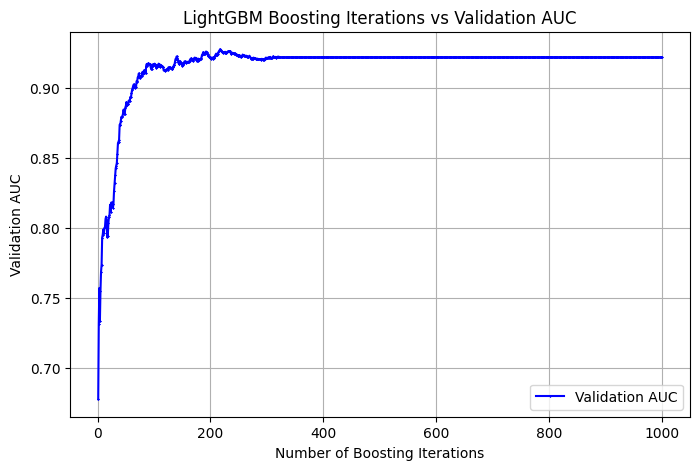

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

dval = lgb.Dataset(X_test, label=y_test, free_raw_data=True)
# Define the range of estimators


evals_result = {}  # Stores validation results
eval_callback = lgb.record_evaluation(evals_result)  # Callback to record results

model = lgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,  # Maximum boosting rounds
    valid_sets=[dval],
    valid_names=["Validation"],
    callbacks=[eval_callback],  # Stores metrics
    # early_stopping_rounds=10,  # Stop if no improvement in 10 rounds
    # verbose_eval=False  # Suppress logging
)

# Extract validation AUC scores
iterations = list(range(1, len(evals_result["Validation"]["auc"]) + 1))
validation_auc = evals_result["Validation"]["auc"]

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(
    iterations,
    validation_auc,
    marker="x",
    linestyle="-",
    color="b",
    label="Validation AUC",
    markersize=1,
)
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("Validation AUC")
plt.title("LightGBM Boosting Iterations vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()

dict_keys(['valid auc-mean', 'valid auc-stdv'])


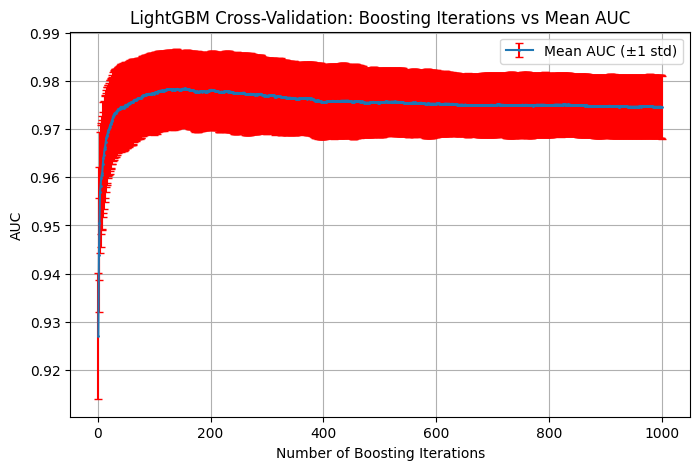

In [15]:
cv_results = lgb.cv(
    params,
    dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds
    stratified=True,  # Stratified sampling for classification
    shuffle=True,  # Shuffle the data before splitting
    # early_stopping_rounds=10,   # Early stopping
    # verbose_eval=False,         # Suppress detailed logging
    seed=42,  # Reproducibility
)

# lgb.cv returns a dictionary containing the mean and standard deviation
# of the metric values across folds for each boosting iteration.
# Usually with metric='auc', you get:
# - cv_results["auc-mean"]
# - cv_results["auc-stdv"]

print(cv_results.keys())
# Extract the mean and standard deviation of the AUC across folds
mean_auc = cv_results["valid auc-mean"]
std_auc = cv_results["valid auc-stdv"]

# Create a list of iteration numbers
iterations = np.arange(1, len(mean_auc) + 1)

# Plot mean AUC vs boosting iterations (with error bars for standard deviation)
plt.figure(figsize=(8, 5))
plt.errorbar(
    iterations,
    mean_auc,
    yerr=std_auc,
    fmt="-o",
    ecolor="r",
    capsize=3,
    label="Mean AUC (±1 std)",
    markersize=1,
)
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("AUC")
plt.title("LightGBM Cross-Validation: Boosting Iterations vs Mean AUC")
plt.grid(True)
plt.legend()
plt.show()

In [64]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

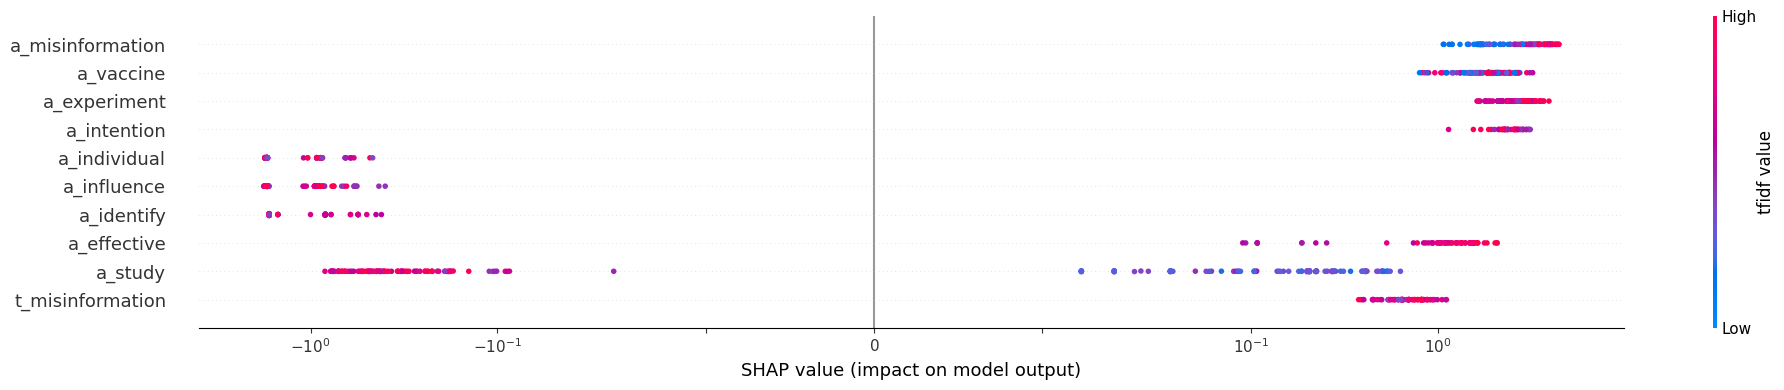

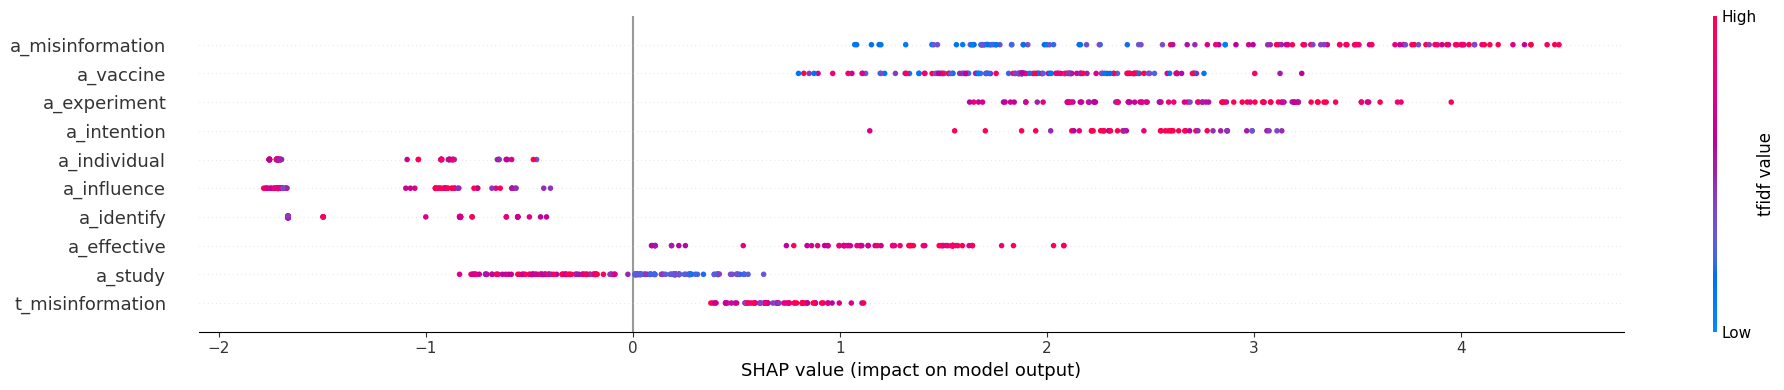

In [65]:
from eppi_text_classification import ShapPlotter

shap_plotter = ShapPlotter(
    model,
    X_test,
    feature_names,
)
dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()
bar_plot.show()

Truth: 0
Prediction: [0]
Shap value: -5.96631299534231
Prediction score: [-5.966313]


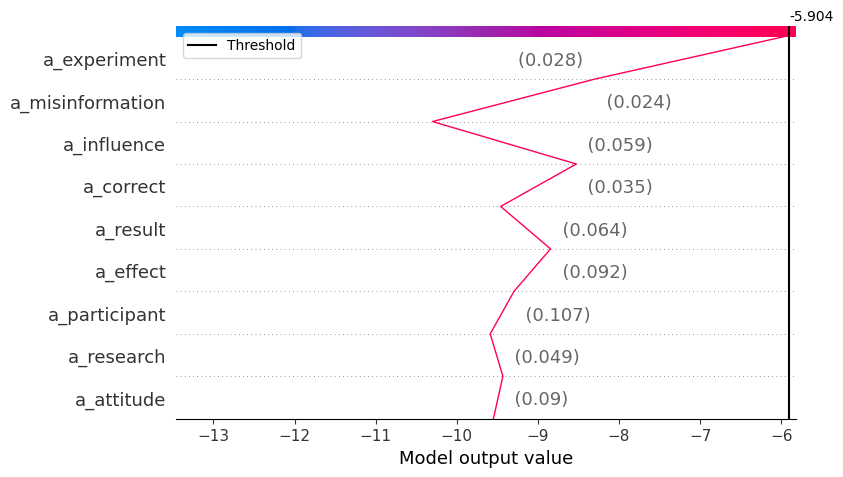

Truth: 0
Prediction: [1]
Shap value: -2.380411446023505
Prediction score: [-2.38041143]


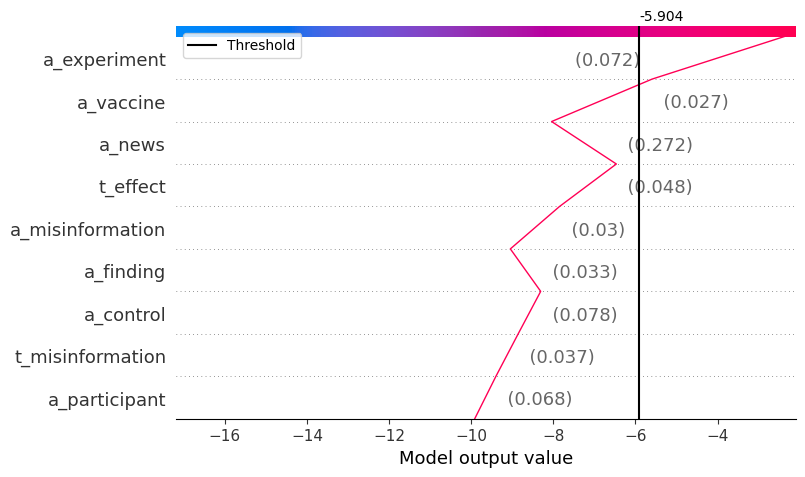

Truth: 0
Prediction: [0]
Shap value: -11.378919225930009
Prediction score: [-11.37891915]


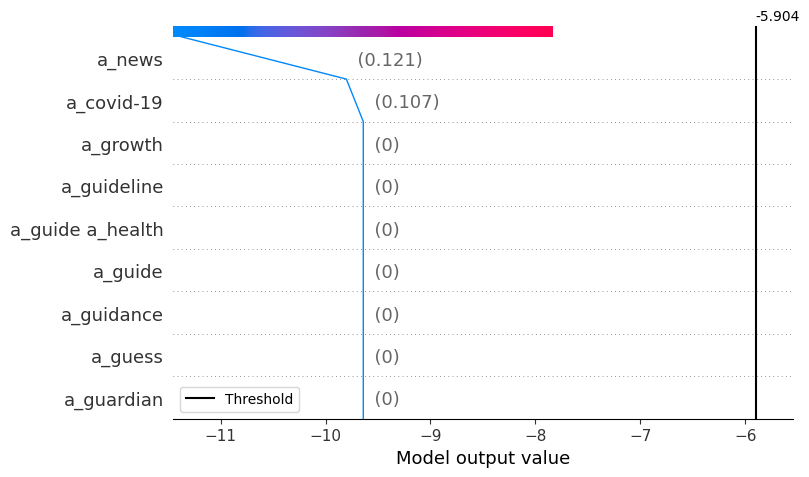

Truth: 0
Prediction: [0]
Shap value: -8.93967435443658
Prediction score: [-8.93967434]


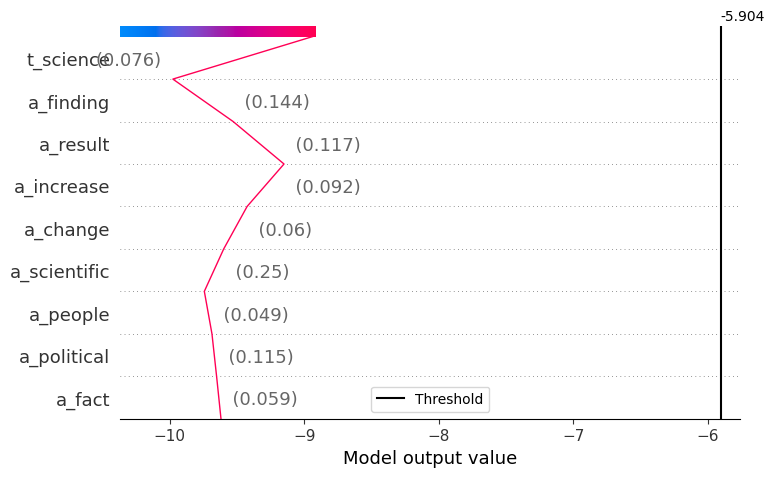

Truth: 0
Prediction: [0]
Shap value: -8.267704468964372
Prediction score: [-8.26770449]


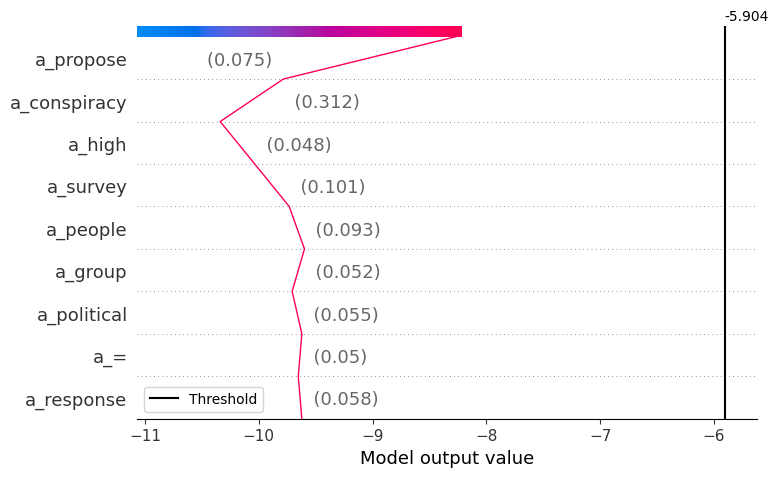

In [66]:
import numpy as np

shap_plotter = ShapPlotter(model, X_test[0:10], feature_names)

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(f"Prediction: {raw_threshold_predict(model, X_test[i], threshold)}")
    print(
        f"Shap value: {shap_plotter.shap_values[i].sum() + shap_plotter.expected_value}"
    )
    print(f"Prediction score: {predict_scores(model, X_test[i])}")
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()